In [1]:
# import sys
# !conda install --yes --prefix {sys.prefix} fbprophet
# !conda install --yes basemap
# !conda install --yes -c conda-forge basemap
# !conda install --yes -c conda-forge basemap-data-hires
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap
import fbprophet
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
import matplotlib.patches as mpatches
print('This must be at least version 0.20.0')
print('If it is not, you must upgrade conda and scikit-learn.')
print(sklearn.__version__)
import warnings
warnings.filterwarnings('ignore')
import googlemaps
from datetime import datetime
gmaps = googlemaps.Client(key='gotta get one from google')
from IPython.display import display
from jupyterthemes import jtplot
jtplot.style()

This must be at least version 0.20.0
If it is not, you must upgrade conda and scikit-learn.
0.20.0


In [2]:
zip_re = pd.read_csv('data/Zip_Zhvi_SingleFamilyResidence.csv', engine='python')

In [3]:
numerics = zip_re.loc[:,'1996-04':'2018-09']
city_num = numerics
city_num = city_num.assign(city=zip_re.City)
groups = pd.melt(city_num, id_vars='city', var_name='month', value_name='price').groupby('city', as_index=False).agg({"price": "median"})
groups = groups.sort_values(by='price', ascending=False)
display('Top Median Price:', groups.head())
display('Bottom Median Price', groups.tail())

'Top Median Price:'

,city,price
247,Atherton,3526200.0
5301,Palm Beach,2700400.0
6590,Snowmass Village,2445700.0
6374,Sea Island,2404100.0
4878,Newport Coast,2145350.0


'Bottom Median Price'

,city,price
7801,Witt,25150.0
7697,Whitmire,25100.0
1899,Earlington,23500.0
5539,Pinewood,22650.0
4276,McColl,11400.0


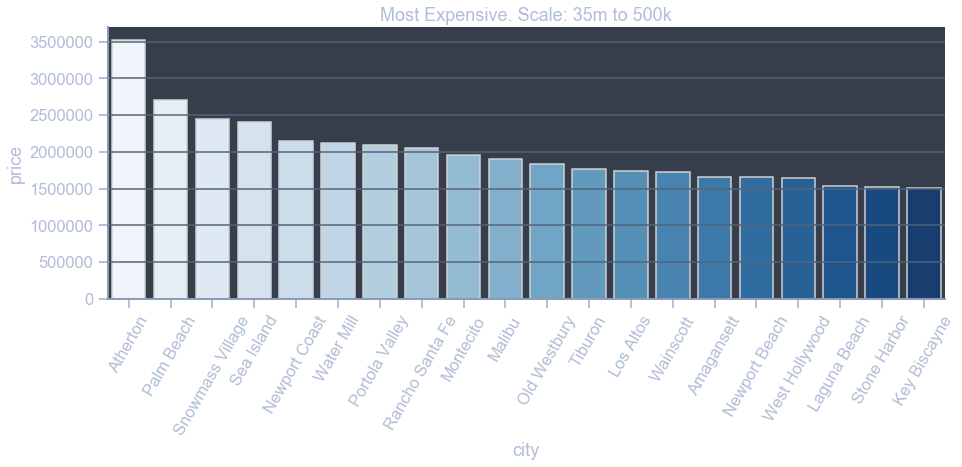

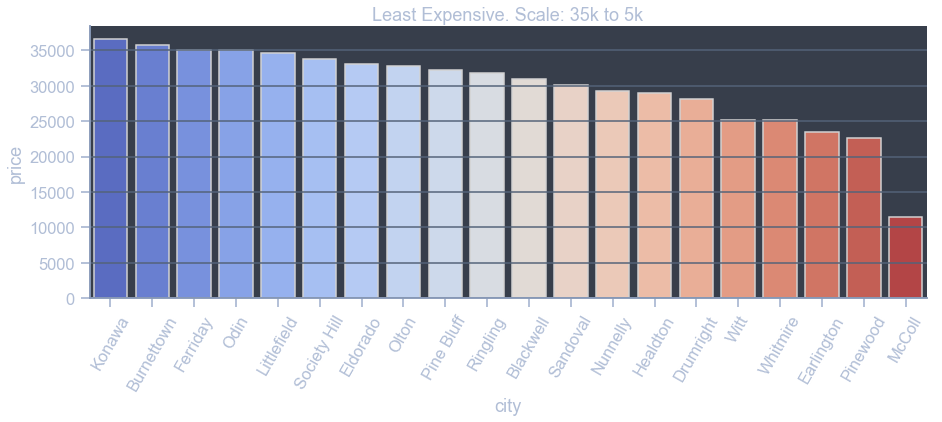

In [4]:
sns.set_context('talk')
top_20 = groups[:20]
bottom_20 = groups[-20:]
group_map = {'Most Expensive. Scale: 35m to 500k': top_20, 'Least Expensive. Scale: 35k to 5k': bottom_20}
palette = 'Blues'
for title, group in group_map.items():
    plt.figure(figsize=(15, 5))
    plt.title(title)
    sns.barplot(
        x=group.city, y=group.price,
        palette=sns.color_palette(palette, 20),
        ec='lightgray'
    )
    sns.despine()
    plt.xticks(rotation=60)
    plt.show()
    palette = 'coolwarm'

In [5]:
city_num = city_num.assign(metro=zip_re.Metro)
city_num = city_num.assign(state=zip_re.State)

In [6]:
def label_rural(x):
    if pd.isnull(x.metro):
        return f'Rural {x.state}'
    return x.metro
temp = city_num.apply(label_rural, axis=1)
city_num = city_num.assign(metro=temp)

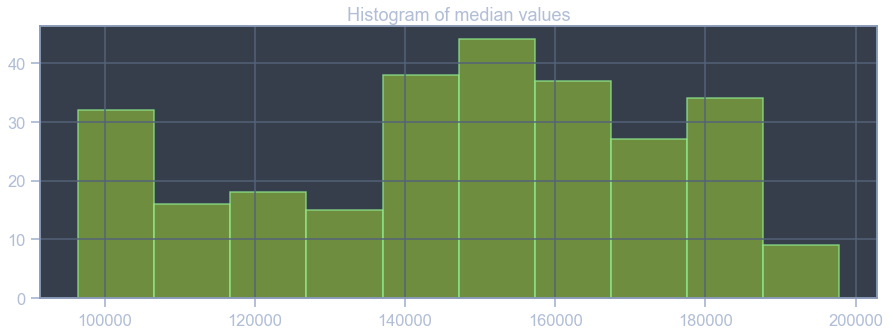

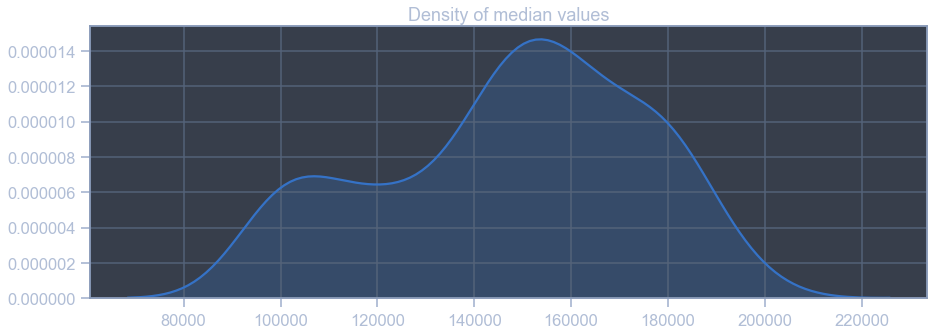

In [7]:
sns.set_context('talk')
city_median = city_num.median()
city_median.index = pd.to_datetime(city_median.index)
city_median.hist(figsize=(15, 5), color='g', alpha=.75, ec='lightgreen')
plt.title('Histogram of median values')
plt.show()
plt.figure(figsize=(15, 5))
sns.kdeplot(city_median, color='b', shade=True)
plt.title('Density of median values')
plt.show()

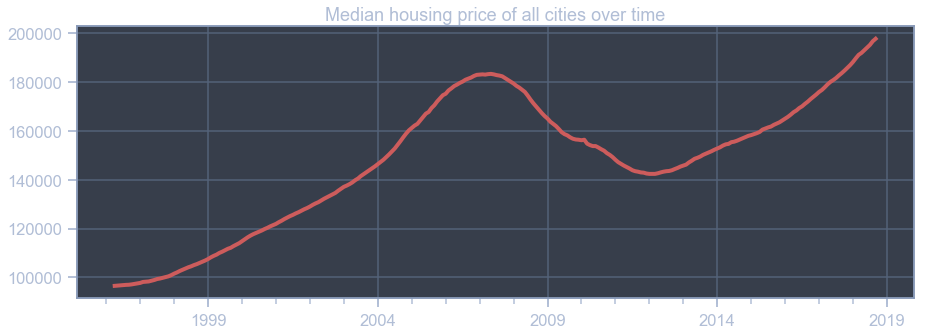

In [8]:
sns.set_context('talk')
plt.figure(figsize=(15, 5))
city_median.plot(linewidth=4, color='indianred')
plt.title('Median housing price of all cities over time')
plt.show()


	Logarithm of individual city housing prices by date per metro area



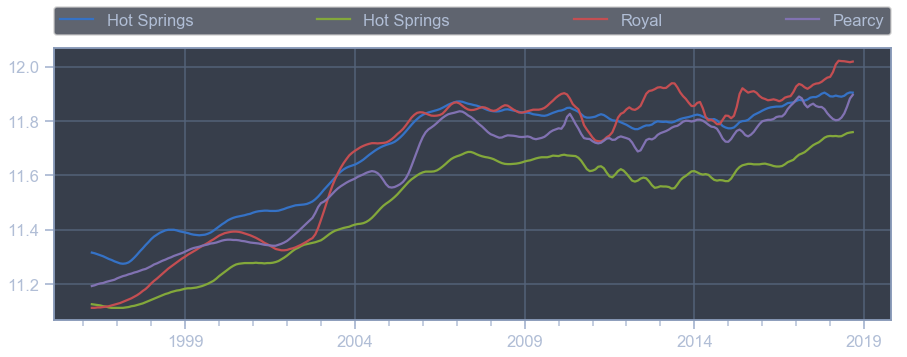

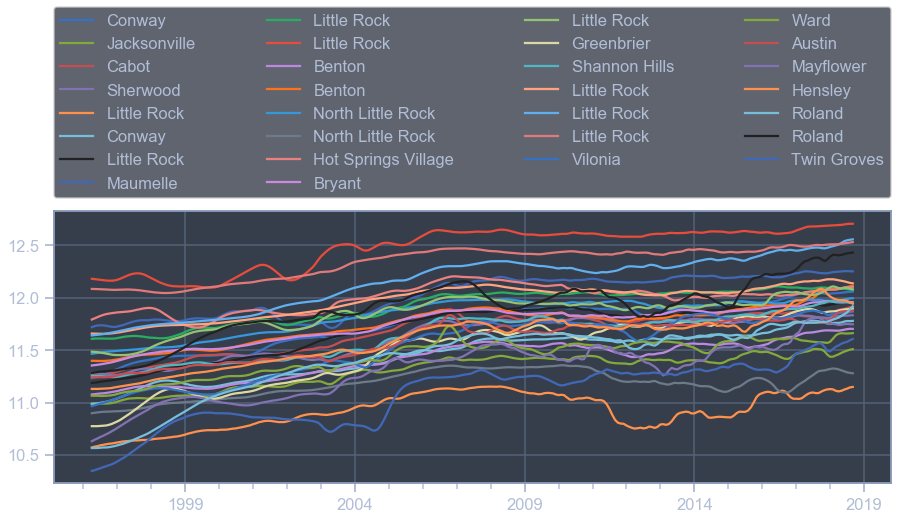

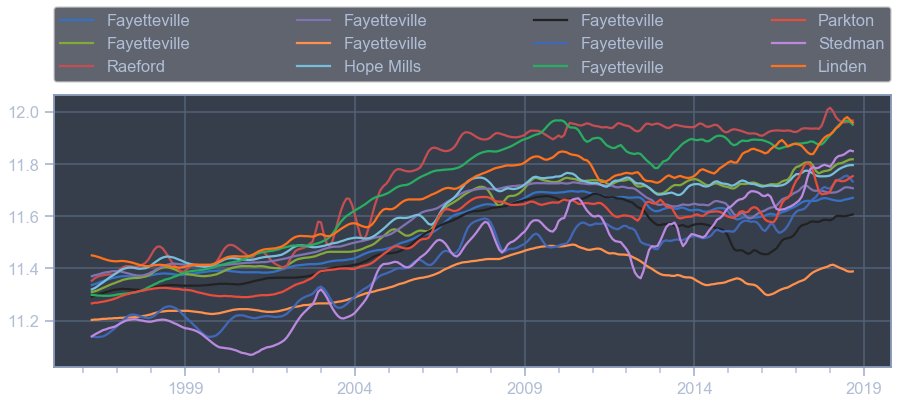

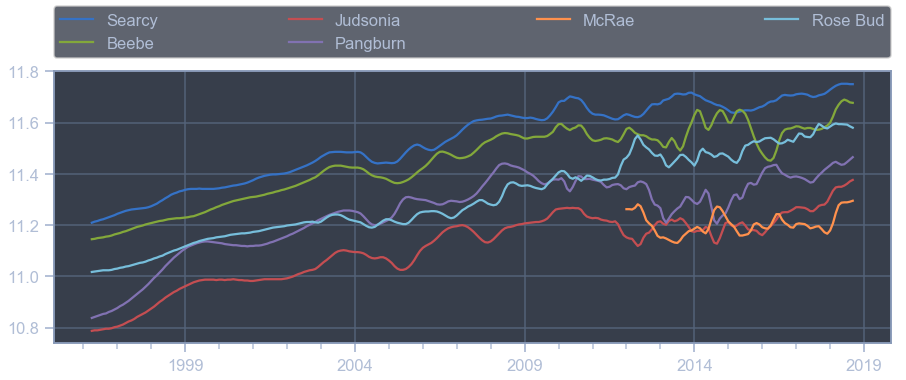

In [9]:

sns.set_context('talk')
names = ['Hot Springs', 'Little Rock-North Little Rock-Conway', 'Fayetteville', 'Searcy']
hot_springs = city_num.loc[city_num.metro == 'Hot Springs']
little_rock = city_num.loc[city_num.metro == 'Little Rock-North Little Rock-Conway']
fayetteville = city_num.loc[city_num.metro == 'Fayetteville']
searcy = city_num.loc[city_num.metro == 'Searcy']
arkansas = [hot_springs, little_rock, fayetteville, searcy]
transformed = []
metro_medians = {}
print('\n\tLogarithm of individual city housing prices by date per metro area\n')
for idx, df in enumerate(arkansas):
    df.drop(['metro', 'state'], axis=1, inplace=True)
    df.set_index('city', inplace=True)
    df.index.rename('date', inplace=True)
    metro_medians[names[idx]] = df.median()
    df = df.T
    df.index = pd.to_datetime(df.index)
    transformed.append(df)
    np.log(df).plot(figsize=(15, 5))
    plt.legend(bbox_to_anchor=(0., 1.05, 1., .0), loc=3, ncol=4, mode='expand', borderaxespad=0.)
    plt.show()


	Median housing price by date per metro area



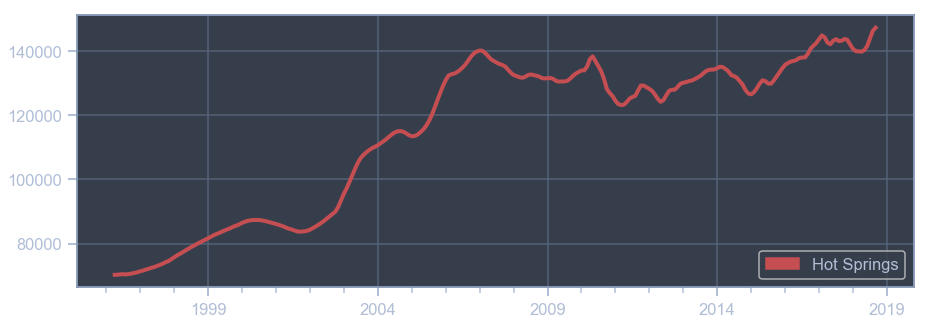

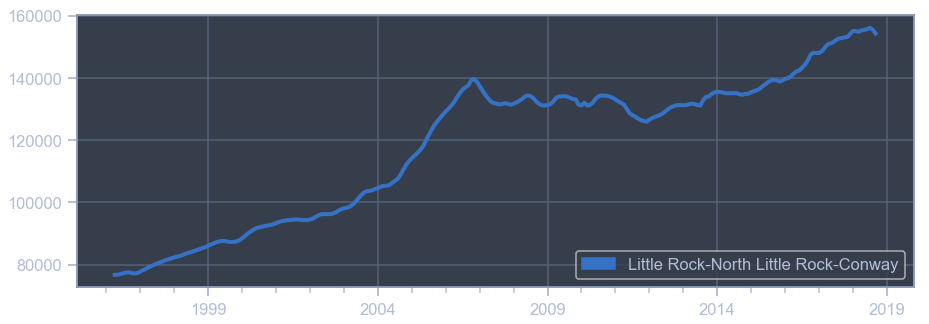

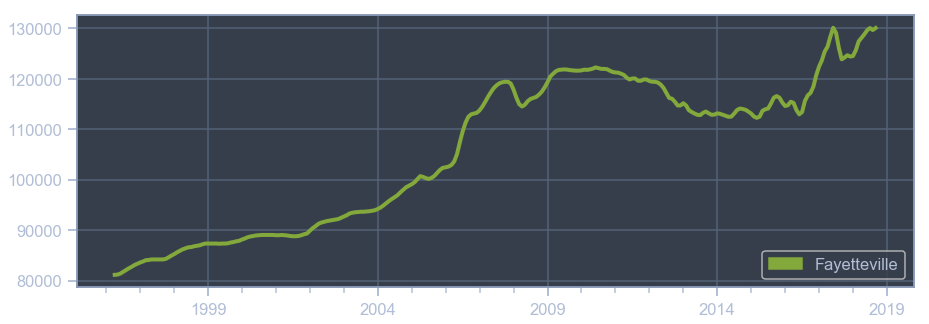

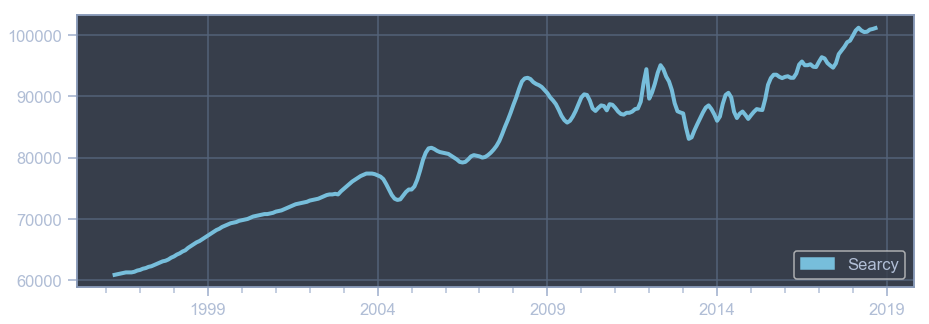

In [10]:
# reference names ['Hot Springs', 'Little Rock-North Little Rock-Conway', 'Fayetteville', 'Searcy']
sns.set_context('talk')
colors = {
    'r': 'Hot Springs',
    'b': 'Little Rock-North Little Rock-Conway',
    'g': 'Fayetteville',
    'c': 'Searcy',
}
idx = 0
print('\n\tMedian housing price by date per metro area\n')
for k, v in colors.items():
    df = metro_medians[v]
    df.index = pd.to_datetime(df.index)
    df.plot(
        figsize=(15, 5), 
        color=k,
        linewidth=4
    )
    plt.legend(
        loc=4,
        handles=[mpatches.Patch(color=k, label=v)]
    )
    idx += 1
    plt.show()

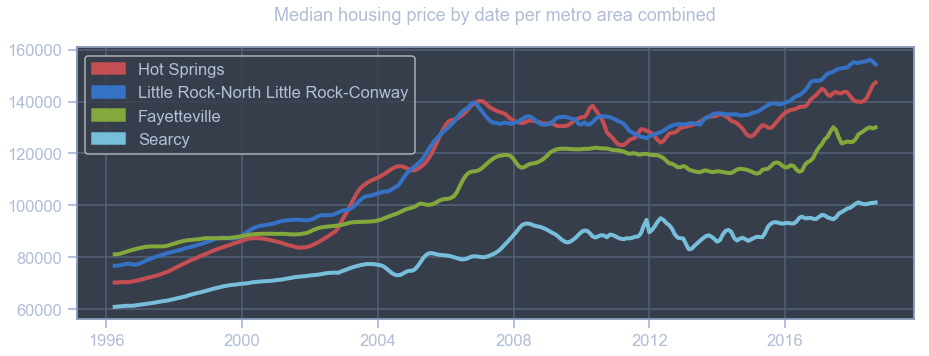

In [11]:
# reference names ['Hot Springs', 'Little Rock-North Little Rock-Conway', 'Fayetteville', 'Searcy']
sns.set_context('talk')
handles = []
plt.figure(figsize=(15, 5))
for k, v in colors.items():
    sns.lineplot(data=metro_medians[v], color=k, linewidth=4)
    handles.append(mpatches.Patch(color=k, label=v))
plt.legend(handles=[handle for handle in handles])
plt.title('Median housing price by date per metro area combined\n')
plt.show()

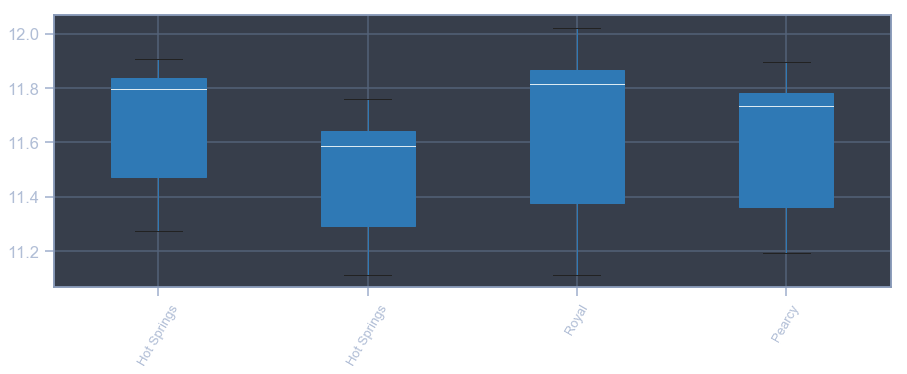

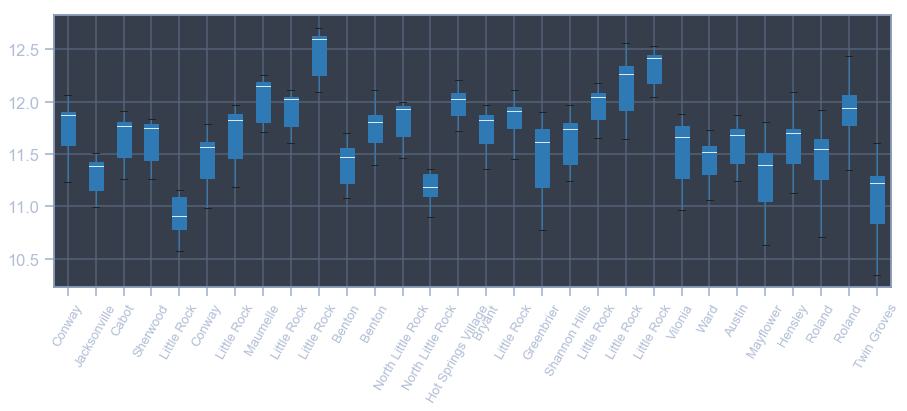

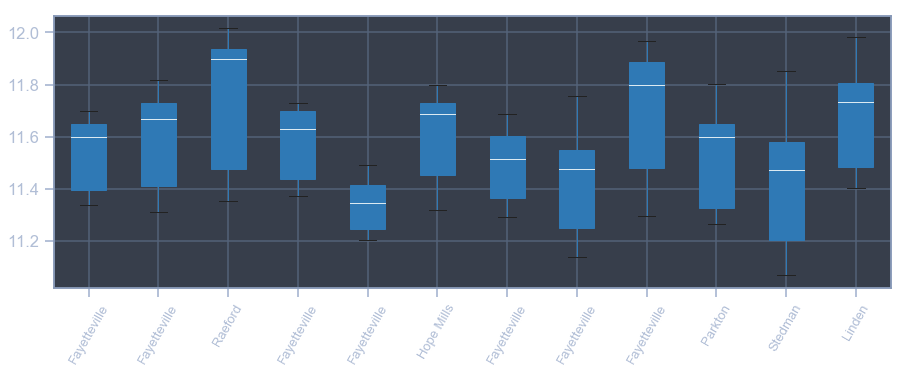

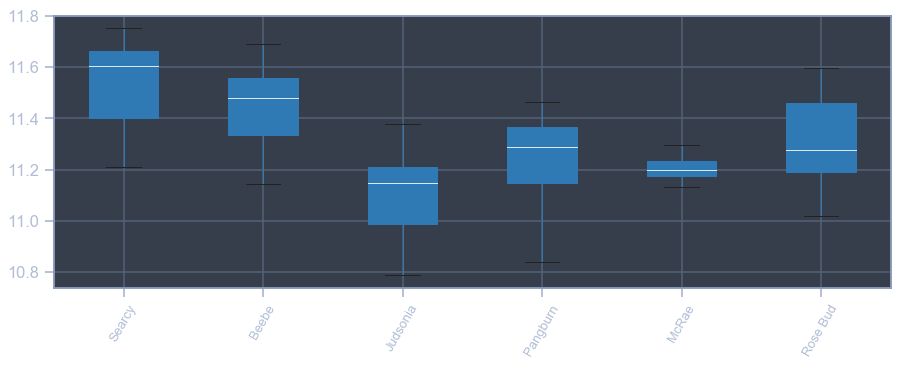

In [12]:
for df in arkansas:
    sns.set_context('talk')
    sns.set_palette('RdBu_r')
    df.index.rename('city', inplace=True)
    np.log(df.T).plot(kind='box', figsize=(15, 5), patch_artist=True)
    plt.xticks(rotation=60, fontsize=13)
    plt.show()

In [13]:
from statsmodels.tsa.stattools import adfuller
sns.set_context('talk')
def test_stationarity(name, timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.figure(figsize=(15, 5))
    mean = plt.plot(rolmean, color='b', label='Rolling Mean', linewidth=4)
    std = plt.plot(rolstd, color='g', label='Rolling Std', linewidth=4)
    plt.legend(loc='best')
    plt.title(f'Rolling mean and standard deviation for {name}')
    plt.show()
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value {key}'] = value
    return(dfoutput)

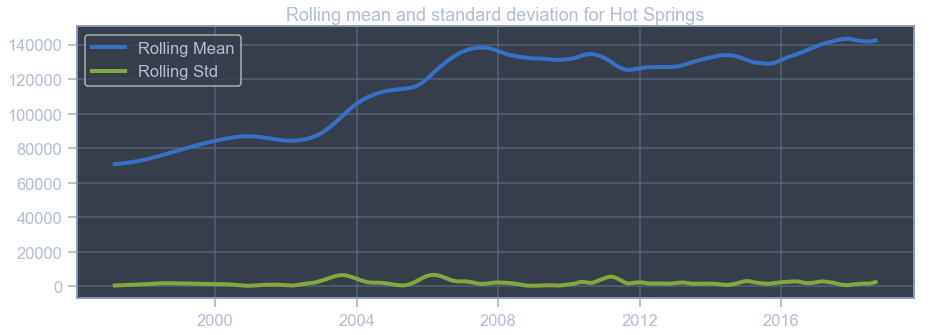

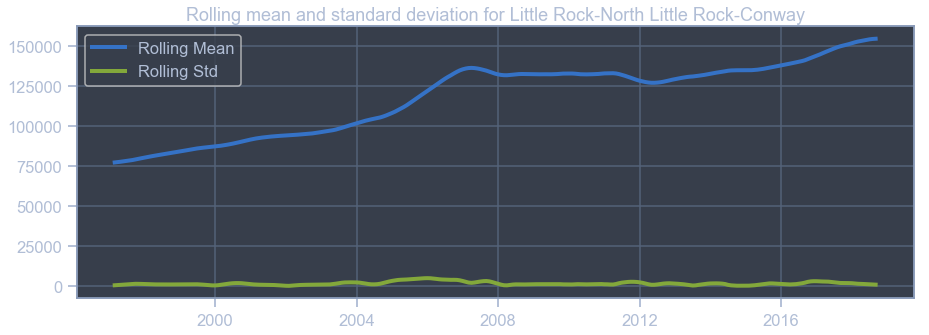

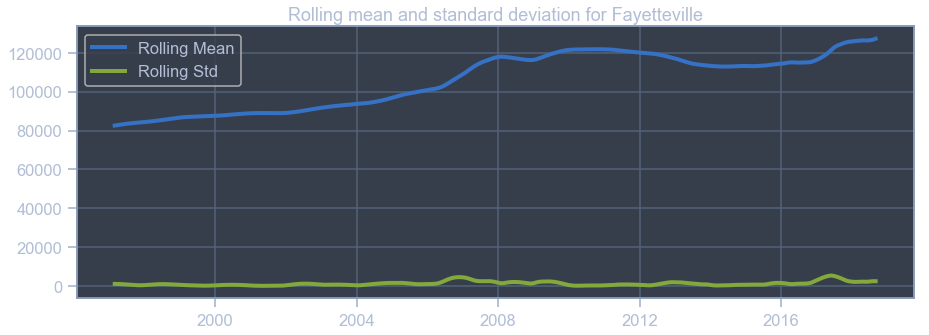

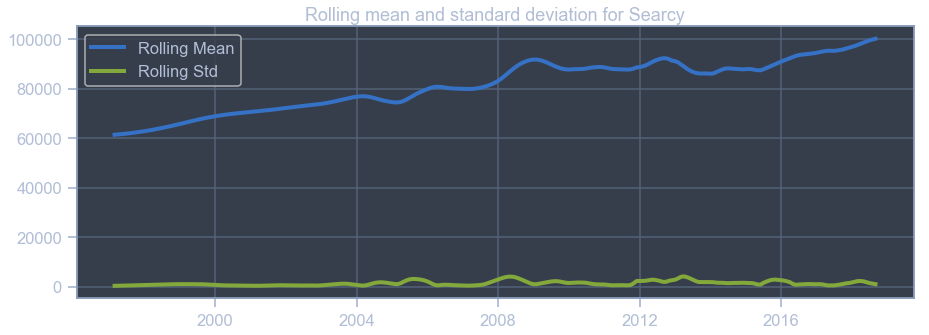

In [14]:
ad_tests = {}
for name, timeseries in metro_medians.items():
    ad_tests[name] = test_stationarity(name, timeseries)

In [15]:
def show_ad():
    for name, test in ad_tests.items():
        display(f'{name} AD Fuller test results', test)
show_ad()

'Hot Springs AD Fuller test results'

Test Statistic       -1.466830
p-value               0.549852
Critical Value 1%    -3.456257
Critical Value 5%    -2.872942
Critical Value 10%   -2.572846
dtype: float64

'Little Rock-North Little Rock-Conway AD Fuller test results'

Test Statistic       -1.287863
p-value               0.634707
Critical Value 1%    -3.455365
Critical Value 5%    -2.872551
Critical Value 10%   -2.572638
dtype: float64

'Fayetteville AD Fuller test results'

Test Statistic       -0.847313
p-value               0.804828
Critical Value 1%    -3.456464
Critical Value 5%    -2.873033
Critical Value 10%   -2.572895
dtype: float64

'Searcy AD Fuller test results'

Test Statistic       -0.888363
p-value               0.791781
Critical Value 1%    -3.455081
Critical Value 5%    -2.872427
Critical Value 10%   -2.572571
dtype: float64

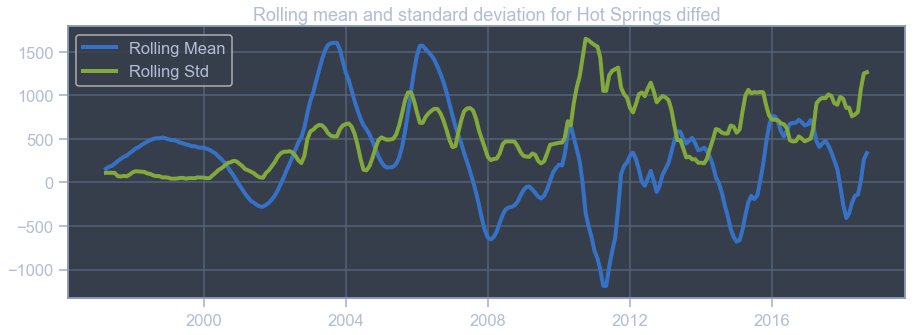

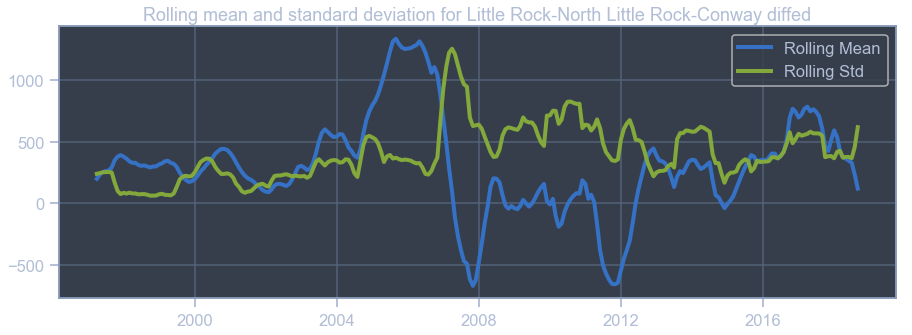

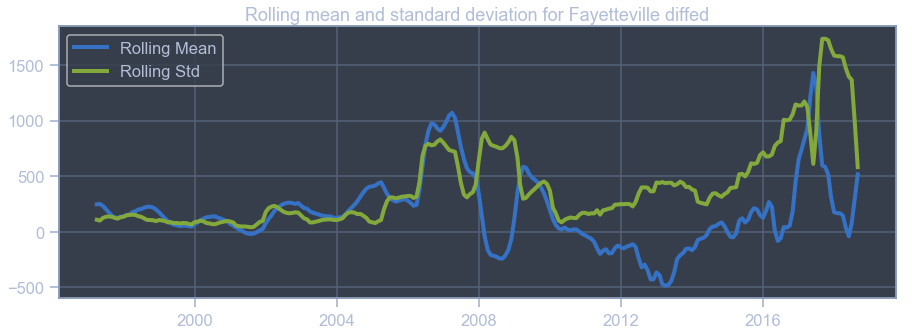

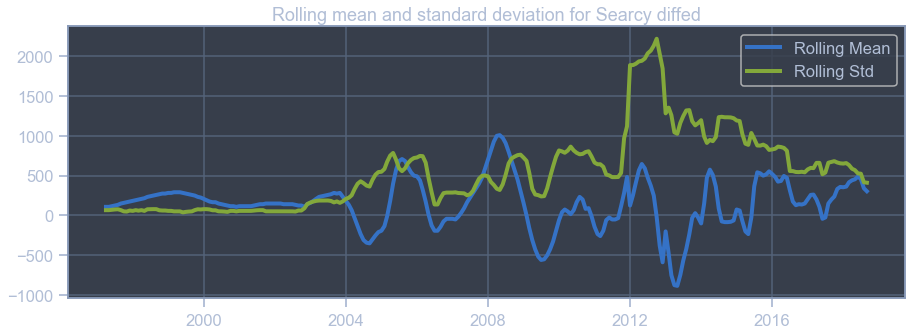

In [16]:
ad_tests = {}
metro_diffed = {}
for name, timeseries in metro_medians.items():
    diff = timeseries.diff()
    diff.dropna(inplace=True)
    name = f'{name} diffed'
    ad_tests[name] = test_stationarity(name, diff)
    metro_diffed[name] = diff

In [17]:
show_ad()

'Hot Springs diffed AD Fuller test results'

Test Statistic       -4.007697
p-value               0.001371
Critical Value 1%    -3.456257
Critical Value 5%    -2.872942
Critical Value 10%   -2.572846
dtype: float64

'Little Rock-North Little Rock-Conway diffed AD Fuller test results'

Test Statistic       -5.097410
p-value               0.000014
Critical Value 1%    -3.455270
Critical Value 5%    -2.872509
Critical Value 10%   -2.572615
dtype: float64

'Fayetteville diffed AD Fuller test results'

Test Statistic       -3.257483
p-value               0.016889
Critical Value 1%    -3.456464
Critical Value 5%    -2.873033
Critical Value 10%   -2.572895
dtype: float64

'Searcy diffed AD Fuller test results'

Test Statistic       -1.006330e+01
p-value               1.316138e-17
Critical Value 1%    -3.455081e+00
Critical Value 5%    -2.872427e+00
Critical Value 10%   -2.572571e+00
dtype: float64

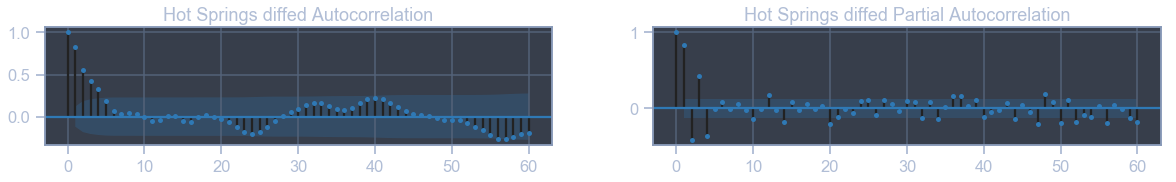

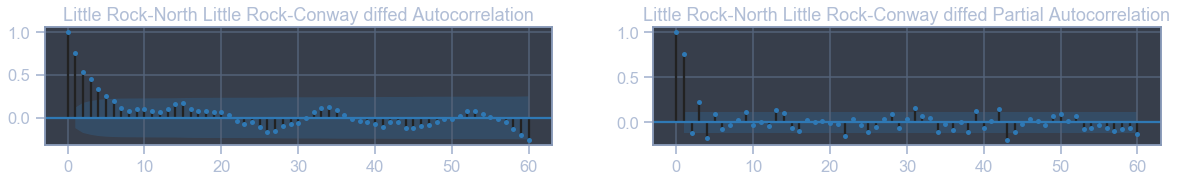

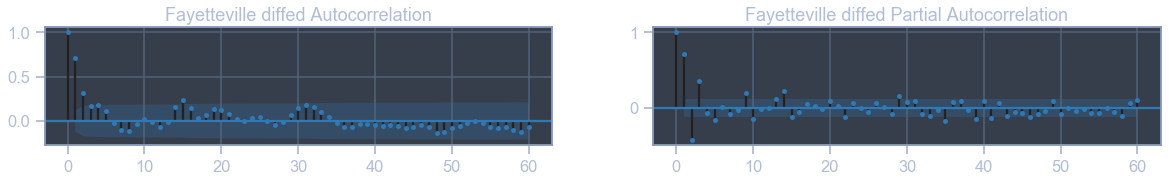

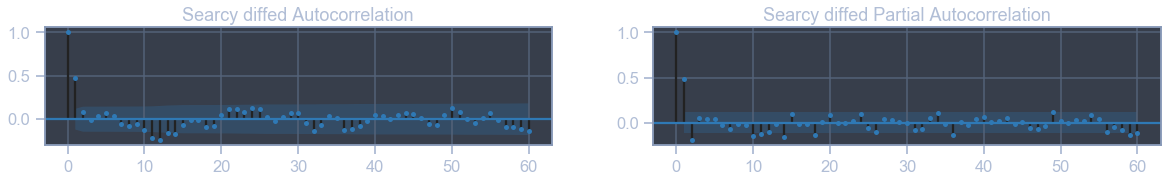

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set_context('talk')
counter = 421
for name, df in metro_diffed.items():
    plt.figure(figsize=(20, 10))
    plt.subplot(counter); plot_acf(df, lags=60, ax=plt.gca(), title=f'{name} Autocorrelation')
    counter += 1
    plt.subplot(counter); plot_pacf(df,  lags=60, ax=plt.gca(), title=f'{name} Partial Autocorrelation')
    counter += 1

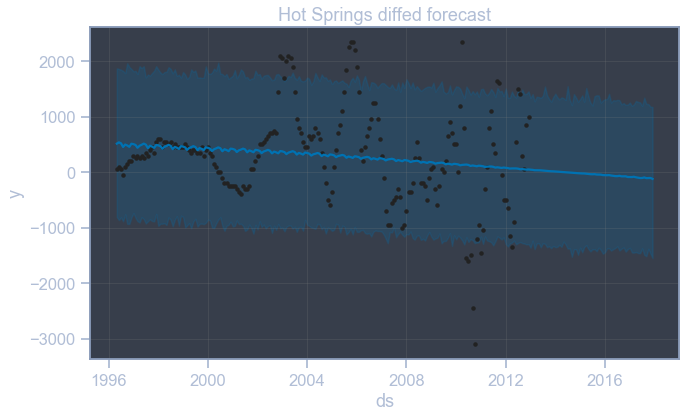

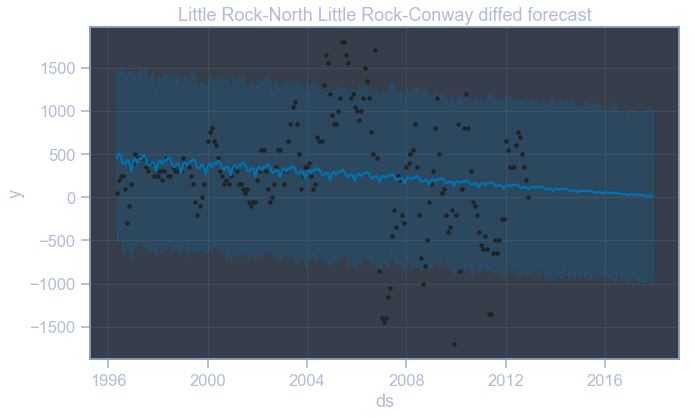

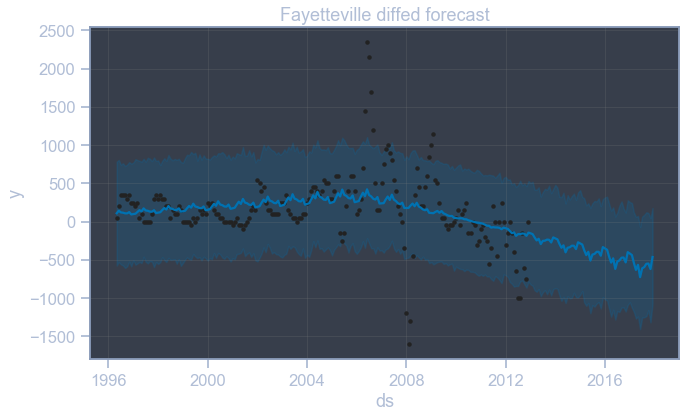

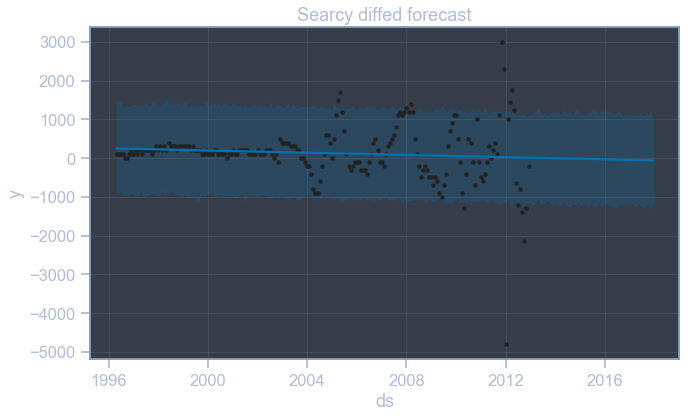

In [19]:
forecasts = {}
for name, df in metro_diffed.items():
    name = f'{name} forecast'
    temp = pd.DataFrame(df[:'2012'])
    temp.reset_index(inplace=True)
    temp.columns = ['ds', 'y']
    prophet_model = Prophet(
        interval_width=0.9, 
        weekly_seasonality=False, 
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )
    prophet_model.fit(temp)
    future = prophet_model.make_future_dataframe(periods=12*5, freq='M')
    forecast = prophet_model.predict(future)
    forecasts[name] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    prophet_model.plot(forecast)
    plt.title(name)
    plt.show()

In [20]:
undiff_acc = {}
for name, df in metro_medians.items():
    temp = df.loc[df.index >  '2013']
    temp_2018 = temp.loc[temp.index < '2018']
    undiff_pred = np.r_[
        temp_2018.iloc[0],
        forecasts[f'{name} diffed forecast'].loc[
            pd.to_datetime(forecasts[f'{name} diffed forecast'].ds) > '2013'
        ].yhat.iloc[1:]].cumsum()
    undiff_acc[name] = pd.DataFrame({
        'actual': temp_2018,
        'predicted': undiff_pred,
        'error': np.absolute(undiff_pred - temp_2018)
    })

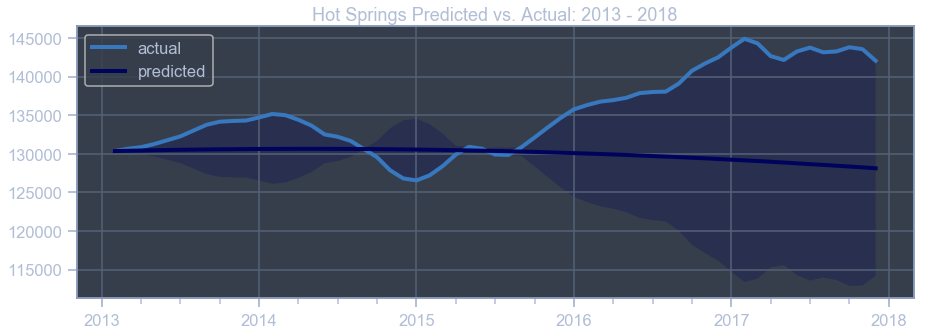

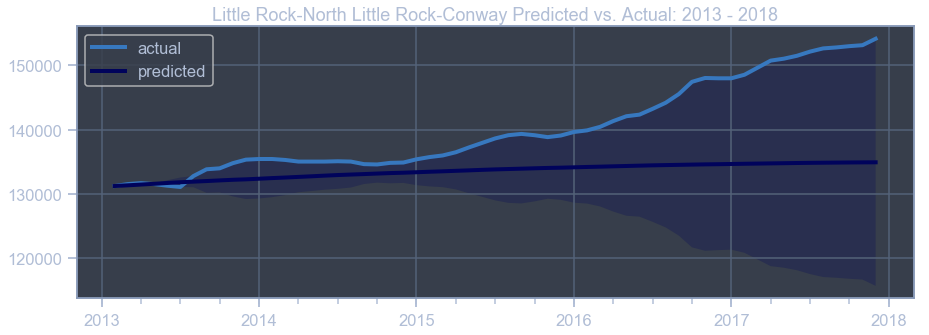

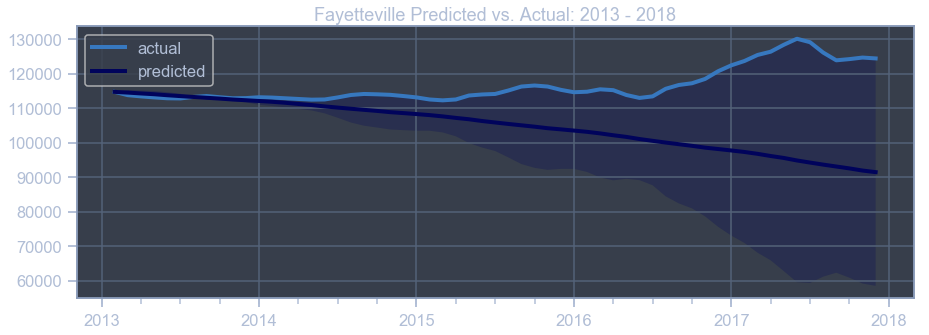

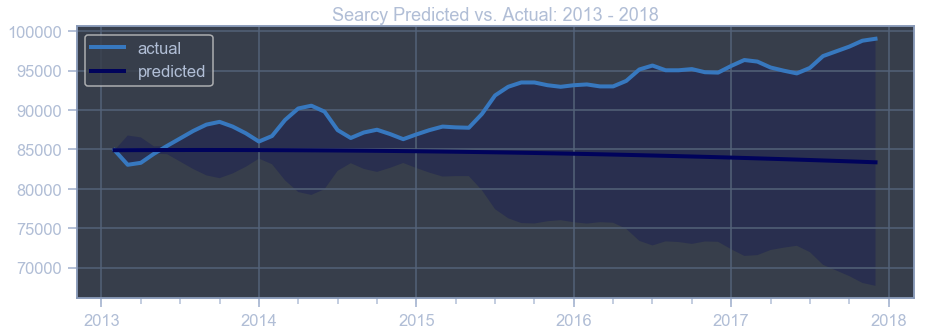

In [21]:
flatui = [
    sns.xkcd_rgb['windows blue'], 
    sns.xkcd_rgb['dark blue'],
]
for name, df in undiff_acc.items():
    sns.set_palette(flatui)
    df.drop('error', axis=1).plot(linewidth=4, figsize=(15, 5))
    x = df.index
    y = df.predicted
    error = df.error
    plt.fill_between(x, y-error, y+error, alpha=0.25, facecolor=flatui[1])
    plt.title(f'{name} Predicted vs. Actual: 2013 - 2018')
    plt.show()

In [22]:
zip_num = numerics
zip_num = zip_num.assign(date_index=zip_re.RegionName) # <-- c'mon Zillow, that's a dumb name for a zip code variable
zip_num = zip_num.set_index('date_index').T
zip_num.index = pd.to_datetime(zip_num.index)
city_num = city_num.assign(zip_code=zip_re.RegionName)

In [23]:
def grind(offset, count):
    workset = zip_num.loc['2001':]
    temp = workset['2018'].T
    workset = workset[temp.loc[temp.median(axis=1) < offset].T.columns.values]
    five_set = workset.loc['2009': '2014']
    ten_set = workset.loc['2004': '2014']
    def find_largest_increase(dataframe):
        result = {}
        result['gross'] = dataframe.apply(lambda x: x.max() - x.min(), axis=0)
        result['percent'] = dataframe.apply(lambda x: (x.max() - x.min()) / x.min(), axis=0)
        result = pd.DataFrame.from_dict(result).reset_index()
        result.columns = ['zip', 'gross', 'percent']
        return result
    five_raise = find_largest_increase(five_set)
    ten_raise = find_largest_increase(ten_set)
    top_percent = list(
        set(five_raise.sort_values(by='percent', ascending=False).head(count).zip.values) \
        & set(ten_raise.sort_values(by='percent', ascending=False).head(count).zip.values)
    )
    top_gross = list(
        set(five_raise.sort_values(by='gross', ascending=False).head(count).zip.values) \
        & set(ten_raise.sort_values(by='gross', ascending=False).head(count).zip.values)
    )
    return [zip_code for zip_code in top_percent if zip_code in top_gross]

In [24]:
full = grind(150e3, round(zip_num.shape[1] * .005))
full_monty = zip_re.loc[zip_re.RegionName.isin(full)]
drop = ['SizeRank', 'RegionID', 'CountyName']
full_monty.drop(drop, axis=1, inplace=True)
full_monty = full_monty.assign(
    zip_code=full_monty.RegionName, 
    city=full_monty.City, 
    state=full_monty.State,
    metro=full_monty.Metro
)
full_monty.drop(['RegionName', 'City', 'State', 'Metro'], axis=1, inplace=True)
high_zip = zip_num[full]
high_zip.shape

(270, 10)

In [101]:
geocode_results = {}
for zip_code in list(high_zip):
    temp = full_monty.loc[full_monty.zip_code == zip_code]
    temp = temp.drop(full_monty.columns[range(0, 249)], axis=1)
    temp = temp.drop(['zip_code', 'city', 'state', 'metro'], axis=1)
    name = full_monty.loc[full_monty.zip_code == zip_code, 'city'].values[0]
    increase = (temp.T.iloc[-1] - temp.T.iloc[0]).values[0]
    zip_code = str(zip_code)
    
    if len(zip_code) < 5:
        zip_code = f'0{zip_code}'
        
    geocode = gmaps.geocode(zip_code)[0]
    geocode_results[name] = {
        'increase' : increase,
        'zip': zip_code,
        'lng': geocode['geometry']['location']['lng'],
        'lat': geocode['geometry']['location']['lat'],
    }

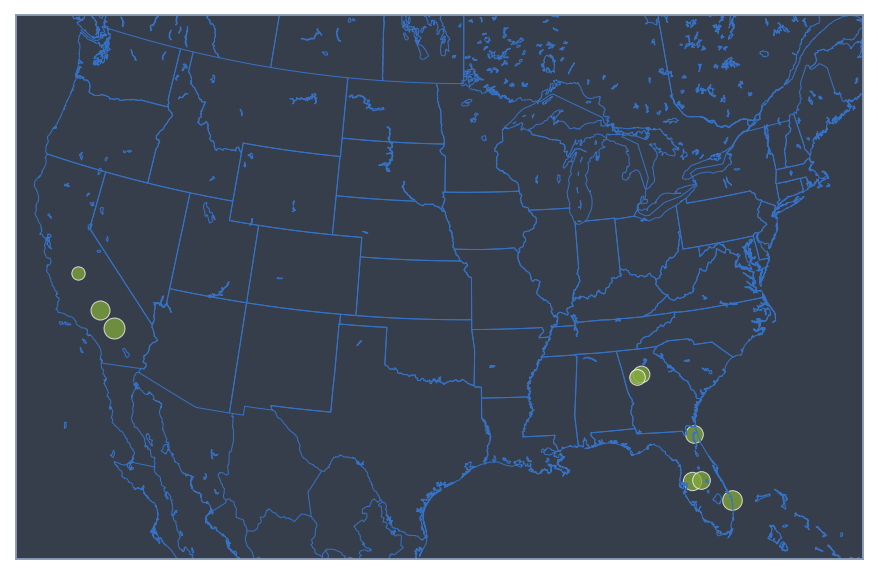

In [102]:
plt.figure(figsize=(20, 10))
m = Basemap(
    llcrnrlon=-119,
    llcrnrlat=22,
    urcrnrlon=-64,
    urcrnrlat=49,
    projection='lcc', 
    lat_1=33,
    lat_2=45,
    lon_0=-95,
    resolution='i'
)
gray = 'b'
m.drawcoastlines(color=gray, linewidth=1)
m.drawstates(color=gray, linewidth=1)
m.drawcountries(color=gray, linewidth=1)
for city in geocode_results.items():
    x, y = m(city[1]['lng'], city[1]['lat'])
    m.scatter(
        x, y, 
        color='g', 
        s=city[1]['increase'] * .01, 
        alpha=.75,
        edgecolor='white',
        linewidth=1
    )
plt.show()

In [117]:
print('Increased value in the "simple algorithmic" recommended areas from January 2017 to September 2018')
pd.DataFrame.from_dict(geocode_results).loc[['zip', 'increase']].T.sort_values(by='increase', ascending=False)

Increased value in the "simple algorithmic" recommended areas from January 2017 to September 2018


,zip,increase
Lucerne Valley,92356,43900
Riviera Beach,33404,38500
California City,93505,36100
Plant City,33563,33600
Dundee,33838,31300
Jacksonville,32211,31100
Panthersville,30034,28200
Union City,30291,24600
Riverdale,30349,19400
Fresno,93706,17800


In [69]:
pop_income = pd.read_csv('data/ACS_14_5YR_S1903_with_ann.csv', na_values=np.nan)
pop_income.drop(pop_income.columns[range(7, 29)], axis=1, inplace=True)
names = ['zip_code', 'pop', 'income', 'white_pop', 'total_white_income', 'black_pop', 'total_black_income']
pop_income.columns = names
pop_income.zip_code = pop_income.zip_code.apply(str.replace, args=['ZCTA5 ', ''])
pop_income.head(3)

,zip_code,pop,income,white_pop,total_white_income,black_pop,total_black_income
0,00601,5820,10833,96.4,10848,0.8,35294
1,00602,13046,16353,58.4,15906,2.4,17371
2,00603,18020,16323,73,16006,4,16346


In [130]:
def fix_zip(x):
    x = str(x)
    if len(x) < 5:
        x = f'0{x}'
    return x
city_num.zip_code = city_num.zip_code.apply(fix_zip)
whole_enchilada = pd.merge(city_num, pop_income, how='left')
whole_enchilada = whole_enchilada.drop(whole_enchilada.columns[range(0, 141)], axis=1)

In [131]:
cat_cols = ['metro', 'state', 'zip_code']
num_cols = ['pop', 'income', 'white_pop', 'total_white_income', 'black_pop', 'total_black_income']
date_attributes = whole_enchilada.iloc[:, 0:129]
cat_attributes = whole_enchilada[cat_cols]
num_attributes = whole_enchilada[num_cols]
ten_year_median = date_attributes.median(axis=1)

In [135]:
whole_enchilada = whole_enchilada[cat_cols + num_cols]
whole_enchilada = whole_enchilada.assign(label=ten_year_median)

,metro,state,zip_code,pop,income,white_pop,total_white_income,black_pop,total_black_income,label
0,Chicago-Naperville-Elgin,IL,60657,36678.0,78796,86.4,81802,2.7,31875,854300.0
1,Houston-The Woodlands-Sugar Land,TX,77494,24787.0,131694,75.8,134929,6.7,81747,258300.0
2,Chicago-Naperville-Elgin,IL,60614,33594.0,88256,88.3,93563,3.6,30283,1134000.0
3,El Paso,TX,79936,34921.0,52088,87.8,52436,2.4,52366,116100.0
4,Houston-The Woodlands-Sugar Land,TX,77449,28521.0,66550,65.5,67345,18.5,64226,129400.0


In [187]:
###
### don't do this. it takes about an hour. 
### not worth it. i made a csv. read from that.
###

# lat_lngs = {}
# missing = []
# counter = 0
# for zip_code in whole_enchilada.zip_code[1466:]:
#     if counter %  1000 == 0:
#         print('.')
#     counter += 1
#     geocode = gmaps.geocode(zip_code)
#     if not len(geocode):
#         missing.append(zip_code)
#         continue
#     geocode = geocode[0]
#     lat_lngs[zip_code] = {
#         'lng': geocode['geometry']['location']['lng'],
#         'lat': geocode['geometry']['location']['lat']
#     }
# def fix_missing(missing):
#     counter = 0
#     for zip_code in missing:
#         if counter %  100 == 0:
#             print('.')
#         counter += 1
#         geocode = gmaps.geocode(zip_code)
#         if not len(geocode):
#             continue
#         geocode = geocode[0]
#         lat_lngs[zip_code] = {
#             'lng': geocode['geometry']['location']['lng'],
#             'lat': geocode['geometry']['location']['lat']
#         }
#         if lat_lngs[zip_code]['lng'] and lat_lngs[zip_code]['lat']:
#             print('got one')
#             missing.remove(zip_code)
# fix_missing(missing)
# print('ding, fries are done.')
# pd.DataFrame.from_dict(lat_lngs).to_csv('data/lat_lngs.csv')

In [219]:
ll_df = pd.DataFrame.from_dict(lat_lngs).T
ll_df = ll_df.reset_index()
ll_df = ll_df.rename(index=str, columns={'index': 'zip_code'})
whole_new = pd.merge(whole_enchilada, ll_df)

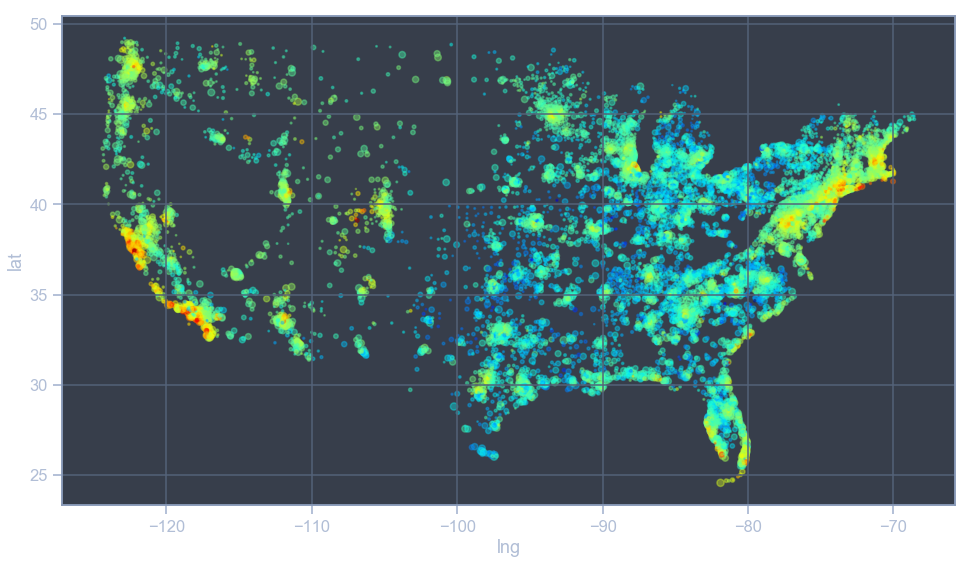

In [260]:
# whole_new.head()
ll_map = whole_new.drop(whole_new.loc[whole_new.lng < -130].index)
ll_map.label = np.log(ll_map.label)
ll_map.plot(
    kind='scatter', x='lng', y='lat', alpha=0.4,
    s=whole_new['pop']/300, figsize=(16, 9),
    c='label', cmap=plt.get_cmap('jet'), colorbar=False
)
plt.show()

,metro,state,zip_code,pop,income,white_pop,total_white_income,black_pop,total_black_income,label,lat,lng
206,Anchorage,AK,99504,14425.0,75835,67.2,87307,11.1,67949,310900.0,61.209679,-149.748436
380,Urban Honolulu,HI,96826,14719.0,44946,21,44716,1,59075,774800.0,21.287772,-157.824191
382,Kahului-Wailuku-Lahaina,HI,96753,10972.0,62748,68.2,57534,1.1,65455,601100.0,20.713224,-156.439054
647,Urban Honolulu,HI,96701,12991.0,83540,19.4,85733,2.5,43362,700100.0,21.387106,-157.910632
704,Urban Honolulu,HI,96707,12003.0,98825,31.2,104713,6.1,107941,526700.0,21.348730,-158.083522
742,Anchorage,AK,99507,14108.0,85739,73.8,89669,4.2,76250,332700.0,61.148769,-149.801081
873,Urban Honolulu,HI,96792,11397.0,56604,19.4,52334,2.5,52548,323100.0,21.484368,-158.166989
968,Urban Honolulu,HI,96786,13018.0,54184,40.9,52433,10.4,51426,459900.0,21.548504,-157.976210
1229,Hilo,HI,96740,12407.0,61750,60.4,64105,0.7,34063,458100.0,19.799291,-155.903629
1344,Urban Honolulu,HI,96813,9766.0,60917,22.2,60533,3,46866,573700.0,21.313615,-157.848036
